In [1]:
import numpy as np
import pandas as pd
import gudhi as gd
from cleaner import cleaner
import datetime
from halvingdates import *

In [2]:
df = pd.read_csv('data/btcall.csv', index_col='Date', parse_dates=True,).sort_index()
df = cleaner(df).astype('float')

In [3]:
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2010-07-18,0.1,0.0,0.1,0.1,80.0,0.00
2010-07-19,0.1,0.1,0.1,0.1,570.0,0.00
2010-07-20,0.1,0.1,0.1,0.1,260.0,0.00
2010-07-21,0.1,0.1,0.1,0.1,580.0,0.00
2010-07-22,0.1,0.1,0.1,0.1,2160.0,0.00
...,...,...,...,...,...,...
2022-06-23,21100.7,19967.3,21189.8,19907.5,110700.0,5.68
2022-06-24,21226.9,21100.9,21488.7,20743.9,104560.0,0.60
2022-06-25,21489.9,21226.9,21553.4,20917.5,66630.0,1.24


# Separating between Halving Dates

I create new columns, each corresponding to the halvings.

In [4]:
half1 = df[halvingdates[0]:halvingdates[2]][['Price']].rename({'Price':'x'}, axis=1)
half2 = df[halvingdates[1]:][['Price']].rename({'Price':'y'}, axis=1)

In [5]:
half12 = pd.concat([half1.reset_index(drop=True), half2.reset_index(drop=True)], axis=1)

## Persistent Homology

In [6]:
def persnorm(df):
    alpha_complex = gd.AlphaComplex(points = df.dropna().values)
    st_alpha = alpha_complex.create_simplex_tree()
    barcode = st_alpha.persistence()
    persist = st_alpha.persistence_intervals_in_dimension(1)
    p = 1
    res = 0
    for i in persist:
        k = i.mean()
        res += (2*k**(p+1)/(p+1))**(1/p)
    return res

def getph(df):
    alpha_complex = gd.AlphaComplex(points = df.dropna().values)
    st_alpha = alpha_complex.create_simplex_tree()
    st_alpha.persistence()
    return st_alpha.persistence_intervals_in_dimension(1)

## Rolling Window

I will use a 7 day and 50 day rolling window and compute the persistence norm.

In [7]:
rolling50 = []
for i in range(len(half12)-50):
    rolling50.append(persnorm(half12[i:i+50]))
rolling7 = []
for i in range(len(half12)-7):
    rolling7.append(persnorm(half12[i:i+7]))

In [8]:
rolling50 = np.array(rolling50)
rolling7 = np.array(rolling7)

In [9]:
adjustedr50 = rolling50[rolling50!=0]

In [10]:
rolling50.mean(), rolling50.std()

(4871559422884.207, 33540627241079.684)

In [11]:
adjustedr50.mean(), adjustedr50.std()

(5984738748481.193, 37086042368393.47)

In [12]:
np.log(adjustedr50).mean(), np.log(adjustedr50).std()

(19.814770119297112, 6.432055483407687)

## Plots

<AxesSubplot:>

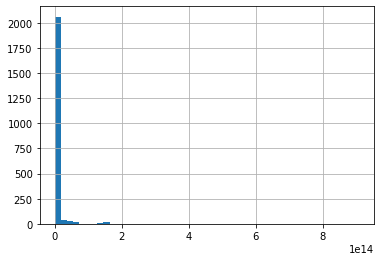

In [13]:
pd.Series(adjustedr50).hist(bins=50)

<AxesSubplot:>

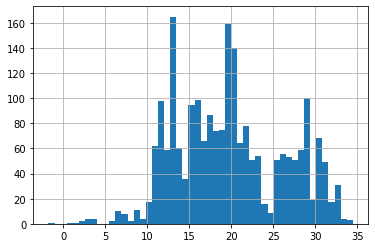

In [14]:
np.log(pd.Series(adjustedr50)).hist(bins=50)

Find the peak days and lowest drop days from the halving date

<AxesSubplot:>

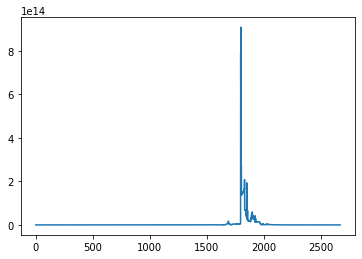

In [15]:
pd.Series(rolling50).plot()

<AxesSubplot:>

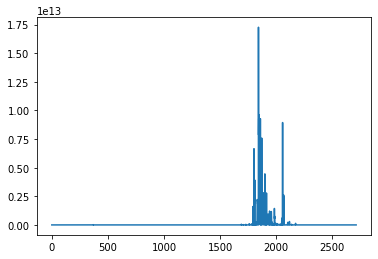

In [16]:
pd.Series(rolling7).plot()

<AxesSubplot:>

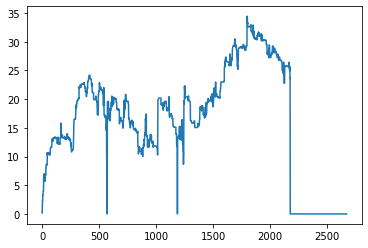

In [24]:
np.log(1+pd.Series(rolling50)).plot()

<AxesSubplot:>

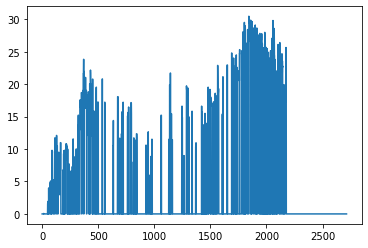

In [25]:
np.log(1+pd.Series(rolling7)).plot()

<AxesSubplot:>

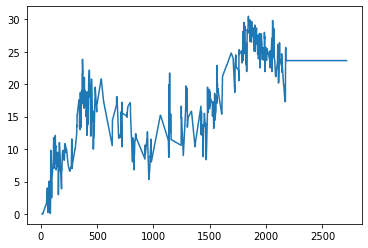

In [31]:
np.log(1+pd.Series(rolling7)).replace({0:np.nan}).interpolate().plot()

<AxesSubplot:>

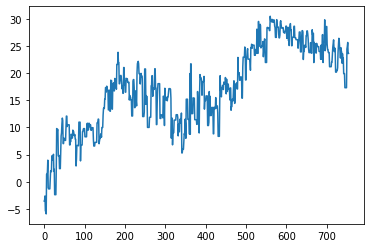

In [20]:
np.log(pd.Series(rolling7[rolling7!=0])).plot()

In [21]:
rolling50.argmax()

1800

<AxesSubplot:>

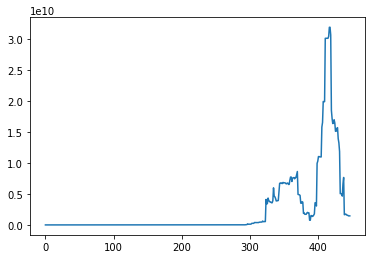

In [22]:
pd.Series(adjustedr50)[:448].plot()

<AxesSubplot:>

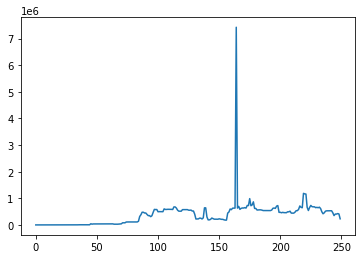

In [23]:
pd.Series(adjustedr50)[:250].plot()

<AxesSubplot:>

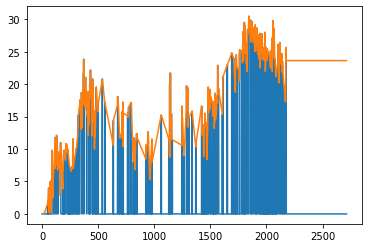